# Préparation des données

## Import et data augmentations

In [11]:
from  src.dataloader import *
from src.metrics import *
from src.resnet18 import *
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import transforms, datasets
import torch.nn as nn
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
import tensorflow as tf
import keras
import keras.layers as layers
from keras.losses import BinaryCrossentropy
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import fbeta_score, make_scorer
import torchvision.models as models
import time

In [2]:
path_train="C:/Users/yanis/OneDrive/Documents/Projet Stat/statapps/train_data.csv"
path_test="C:/Users/yanis/OneDrive/Documents/Projet Stat/statapps/test_data.csv"

# train_dataset  = CustomImageDataset(path_train,"C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/google/img/", transform=transforms.Compose([
#                                                transforms.Resize(224),
#                                                transforms.ToTensor(),

#                                            ]))

# test_dataset = CustomImageDataset(path_test,"C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/google/img/",
#                                             transform=transforms.Compose([
#                                                transforms.Resize(224),
#                                                transforms.ToTensor(),
#                                            ]))

# train_dataloader = DataLoader(train_dataset, batch_size=23045, shuffle=True)
# test_dataloader = DataLoader(test_dataset, batch_size=5762, shuffle=True)

# mean_train, std_train = mean_std(train_dataloader)
# print("Moyenne par channel: {}".format(mean_train.tolist()))
# print("Ecart-type par channel: {}".format(std_train.tolist()))

# mean_test, std_test = mean_std(test_dataloader)
# print("Moyenne par channel: {}".format(mean_test.tolist()))
# print("Ecart-type par channel: {}".format(std_test.tolist()))

721


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 3, 224, 224])
tensor(1)


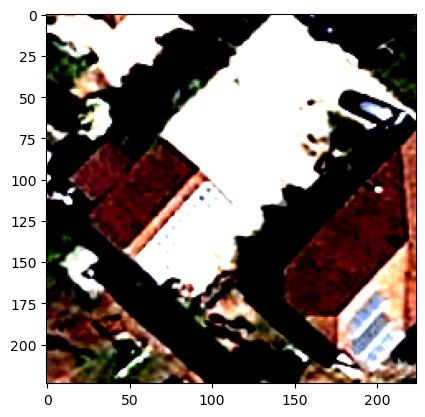

In [5]:
transformed_train_dataset  = CustomImageDataset(path_train,"C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/google/img/", transform=transforms.Compose([
                                               transforms.Resize(224),
                                               transforms.RandomCrop(190), #On garde environ 75% de l'image
                                               transforms.ColorJitter(brightness=(0.5,1.5),contrast=0,saturation=0,hue=0),                                               transforms.RandomCrop(160),
                                               transforms.Resize(224),
                                               transforms.ToTensor(),
                                               transforms.Normalize(mean = [0.3492203652858734, 0.3565990626811981, 0.3071053624153137],
                                                                    std= [0.2003859430551529, 0.18338431417942047, 0.17826561629772186]),

                                           ]))

transformed_test_dataset = CustomImageDataset(path_test,"C:/Users/yanis/OneDrive/Documents/Projet Stat/Données/bdappv/google/img/",
                                            transform=transforms.Compose([
                                               transforms.Resize(224),
                                               transforms.ToTensor(),
                                               transforms.Normalize(mean = [0.3498302698135376, 0.3575190603733063, 0.30798372626304626],
                                                                    std= [0.20142625272274017, 0.1843339055776596, 0.17957480251789093]),
                                           ]))

train_dataloader_augmente = DataLoader(transformed_train_dataset, batch_size=32, shuffle=True)
test_dataloader_augmente = DataLoader(transformed_test_dataset, batch_size=32, shuffle=True)

print(len(train_dataloader_augmente))
batch = next(iter(train_dataloader_augmente))
print(batch[0].shape)
plt.imshow(batch[0][0].permute(1, 2, 0))
print(batch[1][0])

In [7]:
resnet18 = models.resnet18(pretrained=True)

def set_parameter_requires_grad(model, feature_extracting=True):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
            
set_parameter_requires_grad(resnet18)

resnet18.fc = nn.Linear(512, 2)

# Check which layer in the model that will compute the gradient
for name, param in resnet18.named_parameters():
    if param.requires_grad:
        print(name, param.data)

# Here we only want to update the gradient for the classifier layer that we initialized.
params_to_update = []
for name,param in resnet18.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)
            

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\yanis/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [20]:
def train_model(model, train_loader, valid_loader, criterion, optimizer,n_epochs):
    # number of epochs to train the model
    valid_loss_min = np.Inf  # set initial "min" to infinity

    # lists to be plotted at the end of the training

    train_losses, val_losses = [], []

    for epoch in range(n_epochs):

        # monitor losses
        train_loss = 0
        valid_loss = 0

            
        ###################
        # train the model #
        ###################
        model.train() # prep model for training

        for data,label in train_loader:
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output,label)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update running training loss
            train_loss += loss.item() * data.size(0)
            
            
        ######################    
        # validate the model #
        ######################
        model.eval()  # prep model for evaluation
        
        for data,label in valid_loader:
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output,label)
            # update running validation loss 
            valid_loss = loss.item() * data.size(0)

        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = train_loss / len(train_loader.sampler) 
        valid_loss = valid_loss / len(valid_loader.sampler)

        train_losses.append(train_loss)
        val_losses.append(valid_loss) 

        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch+1, 
            train_loss,
            valid_loss
            ))

    # plot of the losses
    plt.plot([*range(len(train_losses))], train_losses / np.sum(train_losses), label = "Train")
    plt.plot([*range(len(train_losses))], val_losses / np.sum(val_losses), label = "Val")
    plt.xlabel('Training epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [23]:
train_model(model=resnet18,
            train_loader=train_dataloader_augmente,
            valid_loader=test_dataloader_augmente, 
            criterion=nn.CrossEntropyLoss(),
            optimizer=torch.optim.SGD(params_to_update,lr = 0.01, momentum=0.9),
            n_epochs=1)

# Lancement du modèle

Les cinq premières métriques représentent les performances de notre algorithme sur l'échantillon d'entrainement, les cinq dernières valeurs (celles précédées du préfixe val_) sont elles calculées sur l'échantillon de test. 

In [ ]:
# model_init = buildModel()
# history=model_init.fit(x = X_train_permute.numpy(), y = Y_train.numpy(),
# 	validation_data=(X_test_permute.numpy(), Y_test.numpy()),
# 	batch_size=32,
# 	epochs=20)

In [ ]:
# recall = history.history['recall_m']
# val_recall = history.history['val_recall_m']

# accuracy = history.history['Accuracy']
# val_accuracy = history.history['val_Accuracy']

# precision = history.history['precision_m']
# val_precision = history.history['val_precision_m']

# f1 = history.history['f1_m']
# val_f1 = history.history['val_f1_m']

# f2 = history.history['f2_m']
# val_f2 = history.history['val_f2_m']

# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs = range(1, len(recall) + 1)

# fig, axs = plt.subplots(3, 2, figsize=(15, 15))

# axs[0, 0].plot(epochs, loss, 'b', label="Loss sur l'échantillon d'apprentissage")
# axs[0, 0].plot(epochs, val_loss, 'b', label="Loss sur l'échantillon test", color="red")
# axs[0, 0].set_title("Loss sur l'échantillon d'apprentissage et l'échantillon test")
# axs[0, 0].legend()

# axs[0, 1].plot(epochs, accuracy, 'b', label="Accuracy sur l'échantillon d'apprentissage")
# axs[0, 1].plot(epochs, val_accuracy, 'b', label="Accuracy sur l'échantillon test", color="red")
# axs[0, 1].set_title("Accuracy sur l'échantillon d'apprentissage et l'échantillon test")
# axs[0, 1].legend()

# axs[1, 0].plot(epochs, precision, 'b', label="Precision sur l'échantillon d'apprentissage")
# axs[1, 0].plot(epochs, val_precision, 'b', label="Precision sur l'échantillon test", color="red")
# axs[1, 0].set_title("Precision sur l'échantillon d'apprentissage et l'échantillon test")
# axs[1, 0].legend()

# axs[1, 1].plot(epochs, recall, 'b', label="Recall sur l'échantillon d'apprentissage")
# axs[1, 1].plot(epochs, val_recall, 'b', label="Recall sur l'échantillon test", color="red")
# axs[1, 1].set_title("Recall sur l'échantillon d'apprentissage et l'échantillon test")
# axs[1, 1].legend()

# axs[2, 0].plot(epochs, f1, 'b', label="F1-score sur l'échantillon d'apprentissage")
# axs[2, 0].plot(epochs, val_f1, 'b', label="F1-score sur l'échantillon test", color="red")
# axs[2, 0].set_title("F1-score sur l'échantillon d'apprentissage et l'échantillon test")
# axs[2, 0].legend()

# axs[2, 1].plot(epochs, f2, 'b', label="F2-score sur l'échantillon d'apprentissage")
# axs[2, 1].plot(epochs, val_f2, 'b', label="F2-score sur l'échantillon test", color="red")
# axs[2, 1].set_title("F2-score sur l'échantillon d'apprentissage et l'échantillon test")
# axs[2, 1].legend()

# plt.show()

In [ ]:
# train_loss, train_accuracy, train_recall, train_precision, train_f1score, train_f2score = model_init.evaluate(
#     X_train_permute.numpy(), Y_train.numpy(), verbose=0)
# print("Loss sur l'échantillon train: {}".format(round(train_loss, 3)))
# print("Accuracy sur l'échantillon train: {}".format(round(train_accuracy, 3)))
# print("Recall sur l'échantillon train: {}".format(round(train_recall, 3)))
# print("Precision sur l'échantillon train: {}".format(round(train_precision, 3)))
# print("F1-score sur l'échantillon train: {}".format(round(train_f1score, 3)))
# print("F2-score sur l'échantillon train: {}".format(round(train_f2score, 3)))

# loss, accuracy, recall, precision, f1score, f2score = model_init.evaluate(
#     X_test_permute.numpy(), Y_test.numpy(), verbose=0)
# print("Loss sur l'échantillon test: {}".format(round(loss, 3)))
# print("Accuracy sur l'échantillon test: {}".format(round(accuracy, 3)))
# print("Recall sur l'échantillon test: {}".format(round(recall, 3)))
# print("Precision sur l'échantillon test: {}".format(round(precision, 3)))
# print("F1-score sur l'échantillon test: {}".format(round(f1score, 3)))
# print("F2-score sur l'échantillon test: {}".format(round(f2score, 3)))

# prob_predict = model_init.predict(X_test_permute.numpy())
# y_pred = (np.squeeze(prob_predict) > 0.5).astype("int32")

# unique, counts = np.unique(y_pred, return_counts=True)
# res=dict(zip(unique, counts))
# print("Nombre d'images prédites avec panneaux: {}".format(res[1]))
# print("Nombre d'images prédites sans panneau: {}".format(res[0]))

Loss sur l'échantillon test: 1.064
Accuracy sur l'échantillon test: 0.438
Recall sur l'échantillon test: 0.706
Precision sur l'échantillon test: 0.48
F1-score sur l'échantillon test: 0.571


# Hyperparamétrisation du ResNet-18

In [ ]:
# learnRate = [1e-2, 1e-3, 1e-4]
# momentum = [0.9, 0.99]
# dropout1 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# dropout2 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# dropout3 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# dropout4 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# dropout5 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# weight_decay=[1e-4, 1e-6]
# batchSize = [4, 8, 16, 32, 64, 128, 256]
# epochs = [10, 20, 30, 40, 50]

# grid = dict(
#     learnRate=learnRate,
#     momentum=momentum,
#     dropout1=dropout1,
#     dropout2=dropout2,
#     dropout3=dropout3,
#     dropout4=dropout4,
#     dropout5=dropout5,
#     weight_decay=weight_decay,
#     batch_size=batchSize,
#     epochs=epochs
# )

# model = KerasClassifier(build_fn=buildModel, verbose=1)
# ftwo_scorer = make_scorer(fbeta_score, beta=2)

# searcher = RandomizedSearchCV(
#     estimator=model, cv=5, n_iter=10, param_distributions=grid, scoring=ftwo_scorer)
# searchResults = searcher.fit(
#     X_train_augmente_permute.numpy(), Y_train_augmente.numpy())
